## Neural Net Models
Purpose of this is to develop the neural network models that make up our final implementation. 

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/MyDrive/Capstone/

Mounted at /content/gdrive
/content/gdrive/MyDrive/Capstone


In [3]:
!pip install transformers

     |████████████████████████████████| 2.1MB 5.3MB/s 
     |████████████████████████████████| 3.3MB 26.1MB/s 
     |████████████████████████████████| 901kB 41.6MB/s 


In [3]:
# !pip install -U sentence-transformers

In [4]:
# other
from tqdm import tqdm, tqdm_notebook, tqdm_pandas

tqdm.pandas()
tqdm_notebook().pandas()

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


In [5]:
import argparse
import copy
import json
import os
import pickle
from datetime import datetime
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

from sklearn.metrics import classification_report, recall_score, f1_score, precision_score
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from tqdm import tqdm

import transformers
from transformers import AdamW, get_cosine_schedule_with_warmup, get_cosine_with_hard_restarts_schedule_with_warmup

In [6]:
def argmax(vec):
    # return the argmax as a python int
    _, idx = torch.max(vec, 1)
    return idx.item()

## Data Processing

In [7]:
user_type_df = pd.read_csv('data/total_user_type.csv')

In [8]:
tf_score_df = pd.read_pickle('data/tf_score_df.pkl')

In [9]:
with open('data/full_df.pkl', 'rb') as f:
  full_df = pickle.load(f)

full_df = train_df.append(test_df).append(val_df)

In [10]:
full_df = full_df.merge(user_type_df, on = 'username').merge(tf_score_df, on ='username')

In [11]:
#hfhn
train_df = full_df[(full_df['type']=='hfhn')&(full_df['split']=='train')]
val_df = full_df[(full_df['type']=='hfhn')&(full_df['split']=='val')]

In [12]:
#hfhn
train_df = full_df[full_df['split']=='train']
val_df = full_df[full_df['split']=='val']

## Dataset

In [15]:
def get_timestamp(x):
    timestamp = []
    for t in x:
        timestamp.append(datetime.timestamp(t))

    np.array(timestamp) - timestamp[-1]
    return timestamp

In [16]:
class SuicidalDataset(Dataset):
    def __init__(self, label, temporal, timestamp, tf_idf_vector):

        super().__init__()
        self.label = label
        self.temporal = temporal
        self.timestamp = timestamp
        self.tf_idf_vector = tf_idf_vector

    def __len__(self):
        return len(self.label)

    def __getitem__(self, item):

        labels = torch.tensor(self.label[item])

        result = self.temporal[item]
        temporal_features = torch.tensor(result)

        tf_idf_vector = self.tf_idf_vector[item]

        timestamp = torch.tensor(get_timestamp(self.timestamp[item]))

        return [labels, temporal_features, timestamp, tf_idf_vector]

In [17]:
def pad_ts_collate(batch):

    target = [item[0] for item in batch]
    data_post = [item[1] for item in batch]
    timestamp_post = [item[2] for item in batch]
    tf_idf_vector = [item[3] for item in batch]

    lens_post = [len(x) for x in data_post]

    data_post = nn.utils.rnn.pad_sequence(data_post, batch_first=True, padding_value=0)

    timestamp_post = nn.utils.rnn.pad_sequence(timestamp_post, batch_first=True, padding_value=0)

    target = torch.tensor(target)
    lens_post = torch.tensor(lens_post)

    tf_idf_vector = torch.tensor(tf_idf_vector).float()

    return [target, data_post, timestamp_post, lens_post, tf_idf_vector]

In [23]:
train_dataset = SuicidalDataset(train_df.label.values,
                                train_df.enc.values,
                                train_df.hist_dates.values,
                                train_df.tf_score.values)

val_dataset = SuicidalDataset(val_df.label.values,
                              val_df.enc.values,
                              val_df.hist_dates.values,
                              val_df.tf_score.values)

BATCH_SIZE = 32
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=pad_ts_collate)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=pad_ts_collate)

## Model Implementation (TLSTM)

In [24]:
class HistoricCurrent(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, subreddit_embedding = 512, dropout = 0.2):
        super().__init__()
        self.historic_model = TimeLSTM(embedding_dim, hidden_dim[0])
        self.dropout = nn.Dropout(dropout) 

        self.fc_tfidf = nn.Linear(799, subreddit_embedding)

        current_dim = hidden_dim[0] + subreddit_embedding #concatenated

        self.layers = nn.ModuleList()
        for hdim in hidden_dim[1:]:
            self.layers.append(nn.Linear(current_dim, hdim))
            current_dim = hdim

        self.layers.append(nn.Linear(current_dim, 2))

    @staticmethod
    def combine_features(features_1, features_2):
        return torch.cat((features_1, features_2), 1)

    def forward(self, historic_features, timestamp, tf_idf_vector):
        outputs = self.historic_model(historic_features, timestamp)
        outputs = torch.mean(outputs, 1)

        subreddit_features = F.relu(self.fc_tfidf(tf_idf_vector))

        combined_features = self.combine_features(subreddit_features, outputs)
        x = self.dropout(combined_features)

        for layer in self.layers[:-1]:
            x = F.relu(layer(x))

        x = self.dropout(x)

        return self.layers[-1](x) # final layer

class TimeLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, bidirectional=True):
        # assumes that batch_first is always true
        super().__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.W_all = nn.Linear(hidden_size, hidden_size * 4)
        self.U_all = nn.Linear(input_size, hidden_size * 4)
        self.W_d = nn.Linear(hidden_size, hidden_size)
        self.bidirectional = bidirectional

    def forward(self, inputs, timestamps, reverse=False):
        # inputs: [b, seq, embed]
        # h: [b, hid]
        # c: [b, hid]
        b, seq, embed = inputs.size()
        h = torch.zeros(b, self.hidden_size, requires_grad=False)
        c = torch.zeros(b, self.hidden_size, requires_grad=False)

        h = h.cuda()
        c = c.cuda()
        outputs = []
        for s in range(seq):
            c_s1 = torch.tanh(self.W_d(c))
            c_s2 = c_s1 * timestamps[:, s:s + 1].expand_as(c_s1)
            c_l = c - c_s1
            c_adj = c_l + c_s2
            outs = self.W_all(h) + self.U_all(inputs[:, s])
            f, i, o, c_tmp = torch.chunk(outs, 4, 1)
            f = torch.sigmoid(f)
            i = torch.sigmoid(i)
            o = torch.sigmoid(o)
            c_tmp = torch.sigmoid(c_tmp)
            c = f * c_adj + i * c_tmp
            h = o * torch.tanh(c)
            outputs.append(h)
        if reverse:
            outputs.reverse()
        outputs = torch.stack(outputs, 1)
        return outputs

In [25]:
def train_loop(model, dataloader, optimizer, device, dataset_len):
    model.train()

    running_loss = 0.0
    running_corrects = 0

    for bi, inputs in enumerate(tqdm_notebook(dataloader, total=len(dataloader), leave=False)):
        
        labels, data, timestamp, lens, tf_idf_vector = inputs

        labels = labels.to(device)
        data = data.to(device)
        timestamp = timestamp.to(device)
        tf_idf_vector = tf_idf_vector.to(device)

        optimizer.zero_grad()
        output = model(data, timestamp,tf_idf_vector)
        _, preds = torch.max(output, 1)

        loss = loss_fn(output, labels, labels.unique(return_counts=True)[1].tolist())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = running_corrects.double() / dataset_len

    return epoch_loss, epoch_acc

In [26]:
def eval_loop(model, dataloader, device, dataset_len):
    model.eval()

    running_loss = 0.0
    running_corrects = 0

    fin_targets = []
    fin_outputs = []

    for bi, inputs in enumerate(tqdm_notebook(dataloader, total=len(dataloader), leave=False)):

        labels, data, timestamp, lens, tf_idf_vector = inputs

        labels = labels.to(device)
        data = data.to(device)
        timestamp = timestamp.to(device)
        tf_idf_vector = tf_idf_vector.to(device)

        with torch.no_grad():
            output = model(data, timestamp, tf_idf_vector)
        _, preds = torch.max(output, 1)
        
        loss = loss_fn(output, labels, labels.unique(return_counts=True)[1].tolist())
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

        fin_targets.append(labels.cpu().detach().numpy())
        fin_outputs.append(preds.cpu().detach().numpy())

    epoch_loss = running_loss / len(dataloader)
    epoch_accuracy = running_corrects.double() / dataset_len

    return epoch_loss, epoch_accuracy, np.hstack(fin_outputs), np.hstack(fin_targets)

## MODEL 0 : HFHN
This was not used in the final implementation.

In [40]:
EPOCHS = 10
HIDDEN_DIM = [64]
EMBEDDING_DIM = 768
SUBREDDIT_EMBEDDING = 64
DROPOUT = 0.7
LEARNING_RATE = 0.001

model = HistoricCurrent(EMBEDDING_DIM, HIDDEN_DIM, SUBREDDIT_EMBEDDING, DROPOUT)
print(model)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

model.to(device)

best_metric = 0.0
best_model_wts = copy.deepcopy(model.state_dict())

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
print(optimizer)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=10, num_training_steps=EPOCHS)
print(scheduler)

HistoricCurrent(
  (historic_model): TimeLSTM(
    (W_all): Linear(in_features=64, out_features=256, bias=True)
    (U_all): Linear(in_features=768, out_features=256, bias=True)
    (W_d): Linear(in_features=64, out_features=64, bias=True)
  )
  (dropout): Dropout(p=0.7, inplace=False)
  (fc_tfidf): Linear(in_features=799, out_features=64, bias=True)
  (layers): ModuleList(
    (0): Linear(in_features=128, out_features=2, bias=True)
  )
)
cuda
AdamW (
Parameter Group 0
    betas: (0.9, 0.999)
    correct_bias: True
    eps: 1e-06
    lr: 0.001
    weight_decay: 0.0
)


In [41]:
train_accuracy = []
val_accuracy = []

train_loss = []
val_loss = []

f1_s = []
recall_s = []
precision_s =[]


for epoch in range(EPOCHS):
  loss, accuracy = train_loop(model, train_dataloader, optimizer, device, len(train_dataset))
  eval_loss, eval_accuracy, __, _ = eval_loop(model, val_dataloader, device, len(val_dataset))

  train_accuracy.append(float(accuracy.cpu()))
  val_accuracy.append(float(eval_accuracy.cpu()))

  train_loss.append(loss)
  val_loss.append(eval_loss)

  metric = f1_score(_, __, average="macro")
  recall_1 = recall_score(_, __, average=None)[1]
  preci_1 = precision_score(_,__, average=None)[1]

  f1_s.append(metric)
  recall_s.append(recall_1)
  precision_s.append(preci_1)

  if scheduler is not None:
      scheduler.step()

  total_metric = [train_accuracy, val_accuracy, train_loss, val_loss, f1_s, recall_s, precision_s]

  with open('tlstm_pc_sep.pkl','wb') as f:
    pickle.dump(total_metric, f)

  print(
      f'epoch {epoch + 1}:: train: loss: {loss:.4f}, accuracy: {accuracy:.4f} | valid: loss: {eval_loss:.4f}, accuracy: {eval_accuracy:.4f}, f1: {metric:.4f}, recall_1: {recall_1:.4f}, precision_1: {preci_1:.4f}')
  if metric > best_metric:
      best_metric = metric
      best_model_wts = copy.deepcopy(model.state_dict())


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


epoch 1:: train: loss: 0.3693, accuracy: 0.5286 | valid: loss: 0.3355, accuracy: 0.5810, f1: 0.5787, recall_1: 0.6626, precision_1: 0.5651


epoch 2:: train: loss: 0.3493, accuracy: 0.5419 | valid: loss: 0.3362, accuracy: 0.6163, f1: 0.6020, recall_1: 0.8153, precision_1: 0.5797


epoch 3:: train: loss: 0.3358, accuracy: 0.5467 | valid: loss: 0.3321, accuracy: 0.6114, f1: 0.6005, recall_1: 0.7857, precision_1: 0.5789


epoch 4:: train: loss: 0.3322, accuracy: 0.5697 | valid: loss: 0.3226, accuracy: 0.6114, f1: 0.6027, recall_1: 0.7685, precision_1: 0.5810


epoch 5:: train: loss: 0.3232, accuracy: 0.5965 | valid: loss: 0.3192, accuracy: 0.6419, f1: 0.6411, recall_1: 0.6970, precision_1: 0.6233


epoch 6:: train: loss: 0.3168, accuracy: 0.6313 | valid: loss: 0.3099, accuracy: 0.6577, f1: 0.6577, recall_1: 0.6724, precision_1: 0.6485


epoch 7:: train: loss: 0.3050, accuracy: 0.6476 | valid: loss: 0.3048, accuracy: 0.6577, f1: 0.6577, recall_1: 0.6798, precision_1: 0.6464


epoch 8:: train: loss: 0.3034, accuracy: 0.6619 | valid: loss: 0.3050, accuracy: 0.6516, f1: 0.6516, recall_1: 0.6502, precision_1: 0.6471


epoch 9:: train: loss: 0.2993, accuracy: 0.6701 | valid: loss: 0.3034, accuracy: 0.6650, f1: 0.6650, recall_1: 0.6675, precision_1: 0.6594


epoch 10:: train: loss: 0.2947, accuracy: 0.6697 | valid: loss: 0.3013, accuracy: 0.6577, f1: 0.6577, recall_1: 0.6601, precision_1: 0.6521


In [73]:
import matplotlib.pyplot as plt
import pickle

with open('tlstm_pc_sep.pkl','rb') as f:
  total_metric = pickle.load(f)

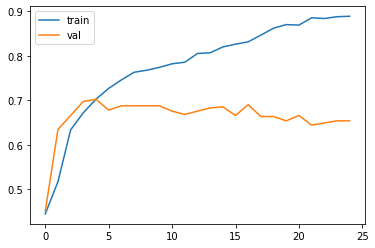

In [74]:
plt.plot(total_metric[0])
plt.plot(total_metric[1])
plt.legend(["train","val"])

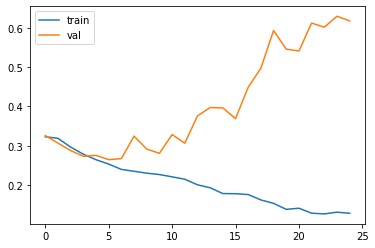

In [75]:
plt.plot(total_metric[2])
plt.plot(total_metric[3])
plt.legend(["train","val"])

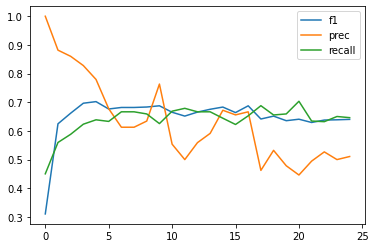

In [76]:
plt.plot(total_metric[4])
plt.plot(total_metric[5])
plt.plot(total_metric[6])
plt.legend(["f1","prec","recall"])

In [36]:
# Saving best model

model_name = "TLSTM_full"
model.load_state_dict(best_model_wts)

if not os.path.exists('saved_model'):
  os.mkdir("saved_model")

torch.save(model.state_dict(), f'saved_model/best_model_{model_name}.pt')

In [29]:
def CB_loss(labels, logits, samples_per_cls, no_of_classes, loss_type, beta, gamma):
    """Compute the Class Balanced Loss between `logits` and the ground truth `labels`.
    Class Balanced Loss: ((1-beta)/(1-beta^n))*Loss(labels, logits)
    where Loss is one of the standard losses used for Neural Networks.
    Args:
      labels: A int tensor of size [batch].
      logits: A float tensor of size [batch, no_of_classes].
      samples_per_cls: A python list of size [no_of_classes].
      no_of_classes: total number of classes. int
      loss_type: string. One of "sigmoid", "focal", "softmax".
      beta: float. Hyperparameter for Class balanced loss.
      gamma: float. Hyperparameter for Focal loss.
    Returns:
      cb_loss: A float tensor representing class balanced loss
    """
    effective_num = 1.0 - np.power(beta, samples_per_cls)
    weights = (1.0 - beta) / np.array(effective_num)
    weights = weights / np.sum(weights) * no_of_classes

    labels_one_hot = F.one_hot(labels, no_of_classes).float()

    weights = torch.tensor(weights, dtype=torch.float32).cuda()
    weights = weights.unsqueeze(0)
    weights = weights.repeat(labels_one_hot.shape[0], 1) * labels_one_hot
    weights = weights.sum(1)
    weights = weights.unsqueeze(1)
    weights = weights.repeat(1, no_of_classes)

    if loss_type == "focal":
        cb_loss = focal_loss(labels_one_hot, logits, weights, gamma)
    elif loss_type == "sigmoid":
        cb_loss = F.binary_cross_entropy_with_logits(input=logits, target=labels_one_hot, weight=weights)
    elif loss_type == "softmax":
        pred = logits.softmax(dim=1)
        cb_loss = F.binary_cross_entropy(input=pred, target=labels_one_hot, weight=weights)

    return cb_loss

def focal_loss(labels, logits, alpha, gamma):
    """Compute the focal loss between `logits` and the ground truth `labels`.
    Focal loss = -alpha_t * (1-pt)^gamma * log(pt)
    where pt is the probability of being classified to the true class.
    pt = p (if true class), otherwise pt = 1 - p. p = sigmoid(logit).
    Args:
      labels: A float tensor of size [batch, num_classes].
      logits: A float tensor of size [batch, num_classes].
      alpha: A float tensor of size [batch_size]
        specifying per-example weight for balanced cross entropy.
      gamma: A float scalar modulating loss from hard and easy examples.
    Returns:
      focal_loss: A float32 scalar representing normalized total loss.
    """
    BCLoss = F.binary_cross_entropy_with_logits(input=logits, target=labels, reduction="none")

    if gamma == 0.0:
        modulator = 1.0
    else:
        modulator = torch.exp(-gamma * labels * logits - gamma * torch.log(1 + torch.exp(-1.0 * logits)))

    loss = modulator * BCLoss

    weighted_loss = alpha * loss
    focal_loss = torch.sum(weighted_loss)

    focal_loss /= torch.sum(labels)
    return focal_loss

def loss_fn(output, targets, samples_per_cls, loss_type = "focal"):
    beta = 0.9999
    gamma = 2.0
    no_of_classes = 2

    return CB_loss(targets, output, samples_per_cls, no_of_classes, loss_type, beta, gamma)

---

## HFHN + LFHN

In [103]:
#hfhn
train_df = full_df[(full_df['type']=='hfhn')&(full_df['split']=='train')|(full_df['type']=='lfhn')&(full_df['split']=='train')]
val_df = full_df[(full_df['type']=='hfhn')&(full_df['split']=='val')]

In [104]:
train_dataset = SuicidalDataset(train_df.label.values,
                                train_df.enc.values,
                                train_df.hist_dates.values,
                                train_df.tf_score.values)

val_dataset = SuicidalDataset(val_df.label.values,
                              val_df.enc.values,
                              val_df.hist_dates.values,
                              val_df.tf_score.values)

BATCH_SIZE = 16
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=pad_ts_collate)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=pad_ts_collate)

In [16]:
class HistoricCurrent(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, subreddit_embedding = 512, dropout = 0.2):
        super().__init__()
        self.historic_model = TimeLSTM(embedding_dim, hidden_dim[0])
        self.dropout = nn.Dropout(dropout) 

        self.fc_tfidf = nn.Linear(799, subreddit_embedding)

        current_dim = hidden_dim[0] + subreddit_embedding #concatenated

        self.layers = nn.ModuleList()
        for hdim in hidden_dim[1:]:
            self.layers.append(nn.Linear(current_dim, hdim))
            current_dim = hdim

        self.layers.append(nn.Linear(current_dim, 2))

    @staticmethod
    def combine_features(features_1, features_2):
        return torch.cat((features_1, features_2), 1)

    def forward(self, historic_features, timestamp, tf_idf_vector):
        outputs = self.historic_model(historic_features, timestamp)
        outputs = torch.mean(outputs, 1)

        subreddit_features = F.relu(self.fc_tfidf(tf_idf_vector))

        combined_features = self.combine_features(subreddit_features, outputs)
        x = self.dropout(combined_features)

        for layer in self.layers[:-1]:
            x = F.relu(layer(x))

        x = self.dropout(x)

        return self.layers[-1](x) # final layer

class TimeLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, bidirectional=True):
        # assumes that batch_first is always true
        super().__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.W_all = nn.Linear(hidden_size, hidden_size * 4)
        self.U_all = nn.Linear(input_size, hidden_size * 4)
        self.W_d = nn.Linear(hidden_size, hidden_size)
        self.bidirectional = bidirectional

    def forward(self, inputs, timestamps, reverse=False):
        # inputs: [b, seq, embed]
        # h: [b, hid]
        # c: [b, hid]
        b, seq, embed = inputs.size()
        h = torch.zeros(b, self.hidden_size, requires_grad=False)
        c = torch.zeros(b, self.hidden_size, requires_grad=False)

        h = h.cuda()
        c = c.cuda()
        outputs = []
        for s in range(seq):
            c_s1 = torch.tanh(self.W_d(c))
            c_s2 = c_s1 * timestamps[:, s:s + 1].expand_as(c_s1)
            c_l = c - c_s1
            c_adj = c_l + c_s2
            outs = self.W_all(h) + self.U_all(inputs[:, s])
            f, i, o, c_tmp = torch.chunk(outs, 4, 1)
            f = torch.sigmoid(f)
            i = torch.sigmoid(i)
            o = torch.sigmoid(o)
            c_tmp = torch.sigmoid(c_tmp)
            c = f * c_adj + i * c_tmp
            h = o * torch.tanh(c)
            outputs.append(h)
        if reverse:
            outputs.reverse()
        outputs = torch.stack(outputs, 1)
        return outputs

In [114]:
HIDDEN_DIM = [128,64]
EMBEDDING_DIM = 768
SUBREDDIT_EMBEDDING = 128
DROPOUT = 0.7
LEARNING_RATE = 0.001

model = HistoricCurrent(EMBEDDING_DIM, HIDDEN_DIM, SUBREDDIT_EMBEDDING, DROPOUT)
print(model)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

model.to(device)

best_metric = 0.0
best_model_wts = copy.deepcopy(model.state_dict())

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
print(optimizer)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=10, num_training_steps=EPOCHS)
print(scheduler)

HistoricCurrent(
  (historic_model): TimeLSTM(
    (W_all): Linear(in_features=128, out_features=512, bias=True)
    (U_all): Linear(in_features=768, out_features=512, bias=True)
    (W_d): Linear(in_features=128, out_features=128, bias=True)
  )
  (dropout): Dropout(p=0.7, inplace=False)
  (fc_tfidf): Linear(in_features=799, out_features=128, bias=True)
  (layers): ModuleList(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=2, bias=True)
  )
)
cuda
AdamW (
Parameter Group 0
    betas: (0.9, 0.999)
    correct_bias: True
    eps: 1e-06
    lr: 0.001
    weight_decay: 0.0
)


In [115]:
EPOCHS = 10

train_accuracy = []
val_accuracy = []

train_loss = []
val_loss = []

f1_s = []
recall_s = []
precision_s =[]


for epoch in range(EPOCHS):
  loss, accuracy = train_loop(model, train_dataloader, optimizer, device, len(train_dataset))
  eval_loss, eval_accuracy, __, _ = eval_loop(model, val_dataloader, device, len(val_dataset))

  train_accuracy.append(float(accuracy.cpu()))
  val_accuracy.append(float(eval_accuracy.cpu()))

  train_loss.append(loss)
  val_loss.append(eval_loss)

  metric = f1_score(_, __, average="macro")
  recall_1 = recall_score(_, __, average=None)[1]
  preci_1 = precision_score(_,__, average=None)[1]

  f1_s.append(metric)
  recall_s.append(recall_1)
  precision_s.append(preci_1)

  if scheduler is not None:
      scheduler.step()

  total_metric = [train_accuracy, val_accuracy, train_loss, val_loss, f1_s, recall_s, precision_s]

  with open('tlstm_pc_sep.pkl','wb') as f:
    pickle.dump(total_metric, f)

  print(
      f'epoch {epoch + 1}:: train: loss: {loss:.4f}, accuracy: {accuracy:.4f} | valid: loss: {eval_loss:.4f}, accuracy: {eval_accuracy:.4f}, f1: {metric:.4f}, recall_1: {recall_1:.4f}, precision_1: {preci_1:.4f}')
  
  if metric > best_metric:
      best_metric = metric
      best_model_wts = copy.deepcopy(model.state_dict())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


epoch 1:: train: loss: 0.3257, accuracy: 0.5378 | valid: loss: 0.3271, accuracy: 0.5496, f1: 0.3547, recall_1: 0.0000, precision_1: 0.0000


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch 2:: train: loss: 0.3180, accuracy: 0.5635 | valid: loss: 0.2952, accuracy: 0.6513, f1: 0.6436, recall_1: 0.8871, precision_1: 0.5729


epoch 3:: train: loss: 0.3133, accuracy: 0.6002 | valid: loss: 0.3000, accuracy: 0.6925, f1: 0.6916, recall_1: 0.8280, precision_1: 0.6185


epoch 4:: train: loss: 0.3027, accuracy: 0.6081 | valid: loss: 0.2915, accuracy: 0.6901, f1: 0.6891, recall_1: 0.8280, precision_1: 0.6160


epoch 5:: train: loss: 0.2947, accuracy: 0.6340 | valid: loss: 0.2726, accuracy: 0.7022, f1: 0.7020, recall_1: 0.8065, precision_1: 0.6329


epoch 6:: train: loss: 0.2797, accuracy: 0.6764 | valid: loss: 0.2587, accuracy: 0.6925, f1: 0.6920, recall_1: 0.7258, precision_1: 0.6398


epoch 7:: train: loss: 0.2595, accuracy: 0.7160 | valid: loss: 0.2792, accuracy: 0.6780, f1: 0.6743, recall_1: 0.6344, precision_1: 0.6448


epoch 8:: train: loss: 0.2501, accuracy: 0.7343 | valid: loss: 0.2782, accuracy: 0.6828, f1: 0.6777, recall_1: 0.6183, precision_1: 0.6571


epoch 9:: train: loss: 0.2454, accuracy: 0.7409 | valid: loss: 0.2843, accuracy: 0.6780, f1: 0.6705, recall_1: 0.5860, precision_1: 0.6606


epoch 10:: train: loss: 0.2361, accuracy: 0.7540 | valid: loss: 0.2988, accuracy: 0.6804, f1: 0.6746, recall_1: 0.6075, precision_1: 0.6570


## HFHN + HFLN



In [14]:
train_df = full_df[(full_df['type']=='hfhn')&(full_df['split']=='train')|(full_df['type']=='hfln')&(full_df['split']=='train')]
val_df = full_df[(full_df['type']=='hfhn')&(full_df['split']=='val')]

In [15]:
train_dataset = SuicidalDataset(train_df.label.values,
                                train_df.enc.values,
                                train_df.hist_dates.values,
                                train_df.tf_score.values)

val_dataset = SuicidalDataset(val_df.label.values,
                              val_df.enc.values,
                              val_df.hist_dates.values,
                              val_df.tf_score.values)

BATCH_SIZE = 16
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=pad_ts_collate)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=pad_ts_collate)

In [23]:
EPOCHS = 10
HIDDEN_DIM = [128,64]
EMBEDDING_DIM = 768
SUBREDDIT_EMBEDDING = 128
DROPOUT = 0.7
LEARNING_RATE = 0.001

model = HistoricCurrent(EMBEDDING_DIM, HIDDEN_DIM, SUBREDDIT_EMBEDDING, DROPOUT)
print(model)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

model.to(device)

best_metric = 0.0
best_model_wts = copy.deepcopy(model.state_dict())

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
print(optimizer)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=10, num_training_steps=EPOCHS)
print(scheduler)

HistoricCurrent(
  (historic_model): TimeLSTM(
    (W_all): Linear(in_features=128, out_features=512, bias=True)
    (U_all): Linear(in_features=768, out_features=512, bias=True)
    (W_d): Linear(in_features=128, out_features=128, bias=True)
  )
  (dropout): Dropout(p=0.7, inplace=False)
  (fc_tfidf): Linear(in_features=799, out_features=128, bias=True)
  (layers): ModuleList(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=2, bias=True)
  )
)
cuda
AdamW (
Parameter Group 0
    betas: (0.9, 0.999)
    correct_bias: True
    eps: 1e-06
    lr: 0.001
    weight_decay: 0.0
)


In [24]:
train_accuracy = []
val_accuracy = []

train_loss = []
val_loss = []

f1_s = []
recall_s = []
precision_s =[]


for epoch in range(EPOCHS):
  loss, accuracy = train_loop(model, train_dataloader, optimizer, device, len(train_dataset))
  eval_loss, eval_accuracy, __, _ = eval_loop(model, val_dataloader, device, len(val_dataset))

  train_accuracy.append(float(accuracy.cpu()))
  val_accuracy.append(float(eval_accuracy.cpu()))

  train_loss.append(loss)
  val_loss.append(eval_loss)

  metric = f1_score(_, __, average="macro")
  recall_1 = recall_score(_, __, average=None)[1]
  preci_1 = precision_score(_,__, average=None)[1]

  f1_s.append(metric)
  recall_s.append(recall_1)
  precision_s.append(preci_1)

  if scheduler is not None:
      scheduler.step()

  total_metric = [train_accuracy, val_accuracy, train_loss, val_loss, f1_s, recall_s, precision_s]

  with open('tlstm_pc_sep.pkl','wb') as f:
    pickle.dump(total_metric, f)

  print(
      f'epoch {epoch + 1}:: train: loss: {loss:.4f}, accuracy: {accuracy:.4f} | valid: loss: {eval_loss:.4f}, accuracy: {eval_accuracy:.4f}, f1: {metric:.4f}, recall_1: {recall_1:.4f}, precision_1: {preci_1:.4f}')
  
  if metric > best_metric:
      best_metric = metric
      best_model_wts = copy.deepcopy(model.state_dict())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch 1:: train: loss: 0.3286, accuracy: 0.5523 | valid: loss: 0.3245, accuracy: 0.5496, f1: 0.3547, recall_1: 0.0000, precision_1: 0.0000


epoch 2:: train: loss: 0.3233, accuracy: 0.5911 | valid: loss: 0.2915, accuracy: 0.6441, f1: 0.6407, recall_1: 0.8226, precision_1: 0.5730


epoch 3:: train: loss: 0.3131, accuracy: 0.6119 | valid: loss: 0.3063, accuracy: 0.6562, f1: 0.6520, recall_1: 0.8495, precision_1: 0.5809


epoch 4:: train: loss: 0.3046, accuracy: 0.6415 | valid: loss: 0.2879, accuracy: 0.6755, f1: 0.6749, recall_1: 0.8011, precision_1: 0.6057


epoch 5:: train: loss: 0.2902, accuracy: 0.6612 | valid: loss: 0.2657, accuracy: 0.7070, f1: 0.7069, recall_1: 0.7634, precision_1: 0.6484


epoch 6:: train: loss: 0.2696, accuracy: 0.7010 | valid: loss: 0.2767, accuracy: 0.6877, f1: 0.6789, recall_1: 0.5806, precision_1: 0.6792


epoch 7:: train: loss: 0.2528, accuracy: 0.7338 | valid: loss: 0.2745, accuracy: 0.6877, f1: 0.6837, recall_1: 0.6398, precision_1: 0.6575


epoch 8:: train: loss: 0.2546, accuracy: 0.7326 | valid: loss: 0.2704, accuracy: 0.6998, f1: 0.6931, recall_1: 0.6129, precision_1: 0.6867


epoch 9:: train: loss: 0.2421, accuracy: 0.7533 | valid: loss: 0.2936, accuracy: 0.6877, f1: 0.6809, recall_1: 0.6022, precision_1: 0.6707


epoch 10:: train: loss: 0.2348, accuracy: 0.7607 | valid: loss: 0.2701, accuracy: 0.6877, f1: 0.6847, recall_1: 0.6559, precision_1: 0.6524


In [25]:
print(best_metric)
model_name = "TLSTM_hfhn_hfln"
model.load_state_dict(best_model_wts)

if not os.path.exists('saved_model'):
  os.mkdir("saved_model")

torch.save(model.state_dict(), f'saved_model/best_model_{model_name}.pt')

0.7069118207677194


## HFLN + LFHN

In [40]:
train_df = full_df[(full_df['type']=='lfln')&(full_df['split']=='train')|(full_df['type']=='hfln')&(full_df['split']=='train')]
val_df = full_df[(full_df['type']=='lfln')&(full_df['split']=='val')]

In [55]:
train_dataset = SuicidalDataset(train_df.label.values,
                                train_df.enc.values,
                                train_df.hist_dates.values,
                                train_df.tf_score.values)

val_dataset = SuicidalDataset(val_df.label.values,
                              val_df.enc.values,
                              val_df.hist_dates.values,
                              val_df.tf_score.values)

BATCH_SIZE = 8
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=pad_ts_collate)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=pad_ts_collate)

In [56]:
EPOCHS = 15
HIDDEN_DIM = [32,16]
EMBEDDING_DIM = 768
SUBREDDIT_EMBEDDING = 32
DROPOUT = 0.7
LEARNING_RATE = 0.001

model = HistoricCurrent(EMBEDDING_DIM, HIDDEN_DIM, SUBREDDIT_EMBEDDING, DROPOUT)
print(model)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

model.to(device)

best_metric = 0.0
best_model_wts = copy.deepcopy(model.state_dict())

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
print(optimizer)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=10, num_training_steps=EPOCHS)
print(scheduler)

HistoricCurrent(
  (historic_model): TimeLSTM(
    (W_all): Linear(in_features=32, out_features=128, bias=True)
    (U_all): Linear(in_features=768, out_features=128, bias=True)
    (W_d): Linear(in_features=32, out_features=32, bias=True)
  )
  (dropout): Dropout(p=0.7, inplace=False)
  (fc_tfidf): Linear(in_features=799, out_features=32, bias=True)
  (layers): ModuleList(
    (0): Linear(in_features=64, out_features=16, bias=True)
    (1): Linear(in_features=16, out_features=2, bias=True)
  )
)
cuda
AdamW (
Parameter Group 0
    betas: (0.9, 0.999)
    correct_bias: True
    eps: 1e-06
    lr: 0.001
    weight_decay: 0.0
)


In [57]:
train_accuracy = []
val_accuracy = []

train_loss = []
val_loss = []

f1_s = []
recall_s = []
precision_s =[]


for epoch in range(EPOCHS):
  loss, accuracy = train_loop(model, train_dataloader, optimizer, device, len(train_dataset))
  eval_loss, eval_accuracy, __, _ = eval_loop(model, val_dataloader, device, len(val_dataset))

  train_accuracy.append(float(accuracy.cpu()))
  val_accuracy.append(float(eval_accuracy.cpu()))

  train_loss.append(loss)
  val_loss.append(eval_loss)

  metric = f1_score(_, __, average="macro")
  recall_1 = recall_score(_, __, average=None)[1]
  preci_1 = precision_score(_,__, average=None)[1]

  f1_s.append(metric)
  recall_s.append(recall_1)
  precision_s.append(preci_1)

  if scheduler is not None:
      scheduler.step()

  total_metric = [train_accuracy, val_accuracy, train_loss, val_loss, f1_s, recall_s, precision_s]

  with open('tlstm_pc_sep.pkl','wb') as f:
    pickle.dump(total_metric, f)

  print(
      f'epoch {epoch + 1}:: train: loss: {loss:.4f}, accuracy: {accuracy:.4f} | valid: loss: {eval_loss:.4f}, accuracy: {eval_accuracy:.4f}, f1: {metric:.4f}, recall_1: {recall_1:.4f}, precision_1: {preci_1:.4f}')
  
  if metric > best_metric:
      best_metric = metric
      best_model_wts = copy.deepcopy(model.state_dict())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


epoch 1:: train: loss: 0.3212, accuracy: 0.4642 | valid: loss: 0.3012, accuracy: 0.4608, f1: 0.3154, recall_1: 0.0000, precision_1: 0.0000


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch 2:: train: loss: 0.3163, accuracy: 0.4620 | valid: loss: 0.3128, accuracy: 0.4608, f1: 0.3154, recall_1: 0.0000, precision_1: 0.0000


epoch 3:: train: loss: 0.3106, accuracy: 0.4713 | valid: loss: 0.3205, accuracy: 0.4853, f1: 0.3709, recall_1: 0.0545, precision_1: 0.8571


epoch 4:: train: loss: 0.3094, accuracy: 0.4868 | valid: loss: 0.3192, accuracy: 0.5319, f1: 0.4553, recall_1: 0.8409, precision_1: 0.5425


epoch 5:: train: loss: 0.3049, accuracy: 0.4958 | valid: loss: 0.3209, accuracy: 0.5735, f1: 0.5109, recall_1: 0.8636, precision_1: 0.5689


epoch 6:: train: loss: 0.3046, accuracy: 0.5323 | valid: loss: 0.2964, accuracy: 0.5882, f1: 0.5765, recall_1: 0.7000, precision_1: 0.6016


epoch 7:: train: loss: 0.3010, accuracy: 0.5595 | valid: loss: 0.3133, accuracy: 0.6495, f1: 0.6386, recall_1: 0.7636, precision_1: 0.6486


epoch 8:: train: loss: 0.2929, accuracy: 0.5860 | valid: loss: 0.2987, accuracy: 0.6593, f1: 0.6539, recall_1: 0.7273, precision_1: 0.6695


epoch 9:: train: loss: 0.2864, accuracy: 0.6170 | valid: loss: 0.2931, accuracy: 0.6544, f1: 0.6527, recall_1: 0.6727, precision_1: 0.6820


epoch 10:: train: loss: 0.2868, accuracy: 0.6230 | valid: loss: 0.2815, accuracy: 0.6520, f1: 0.6467, recall_1: 0.7182, precision_1: 0.6639


epoch 11:: train: loss: 0.2771, accuracy: 0.6540 | valid: loss: 0.2721, accuracy: 0.6348, f1: 0.6329, recall_1: 0.6545, precision_1: 0.6636


epoch 12:: train: loss: 0.2736, accuracy: 0.6585 | valid: loss: 0.2882, accuracy: 0.6201, f1: 0.6182, recall_1: 0.6409, precision_1: 0.6498


epoch 13:: train: loss: 0.2715, accuracy: 0.6805 | valid: loss: 0.2956, accuracy: 0.6176, f1: 0.6150, recall_1: 0.6500, precision_1: 0.6441


epoch 14:: train: loss: 0.2599, accuracy: 0.7005 | valid: loss: 0.3009, accuracy: 0.6225, f1: 0.6199, recall_1: 0.6545, precision_1: 0.6486


epoch 15:: train: loss: 0.2673, accuracy: 0.6980 | valid: loss: 0.3060, accuracy: 0.6176, f1: 0.6150, recall_1: 0.6500, precision_1: 0.6441


In [58]:
print(best_metric)
model_name = "TLSTM_hfln_lfln"
model.load_state_dict(best_model_wts)

if not os.path.exists('saved_model'):
  os.mkdir("saved_model")

torch.save(model.state_dict(), f'saved_model/best_model_{model_name}.pt')

0.6539060068471833


## LFLN + LFHN

In [59]:
train_df = full_df[(full_df['type']=='lfln')&(full_df['split']=='train')|(full_df['type']=='lfhn')&(full_df['split']=='train')]
val_df = full_df[(full_df['type']=='lfln')&(full_df['split']=='val')]

In [63]:
train_dataset = SuicidalDataset(train_df.label.values,
                                train_df.enc.values,
                                train_df.hist_dates.values,
                                train_df.tf_score.values)

val_dataset = SuicidalDataset(val_df.label.values,
                              val_df.enc.values,
                              val_df.hist_dates.values,
                              val_df.tf_score.values)

BATCH_SIZE = 16
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=pad_ts_collate)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=pad_ts_collate)

In [72]:
EPOCHS = 15
HIDDEN_DIM = [8]
EMBEDDING_DIM = 768
SUBREDDIT_EMBEDDING = 8
DROPOUT = 0.7
LEARNING_RATE = 0.001

model = HistoricCurrent(EMBEDDING_DIM, HIDDEN_DIM, SUBREDDIT_EMBEDDING, DROPOUT)
print(model)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

model.to(device)

best_metric = 0.0
best_model_wts = copy.deepcopy(model.state_dict())

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
print(optimizer)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=10, num_training_steps=EPOCHS)
print(scheduler)

HistoricCurrent(
  (historic_model): TimeLSTM(
    (W_all): Linear(in_features=8, out_features=32, bias=True)
    (U_all): Linear(in_features=768, out_features=32, bias=True)
    (W_d): Linear(in_features=8, out_features=8, bias=True)
  )
  (dropout): Dropout(p=0.7, inplace=False)
  (fc_tfidf): Linear(in_features=799, out_features=8, bias=True)
  (layers): ModuleList(
    (0): Linear(in_features=16, out_features=2, bias=True)
  )
)
cuda
AdamW (
Parameter Group 0
    betas: (0.9, 0.999)
    correct_bias: True
    eps: 1e-06
    lr: 0.001
    weight_decay: 0.0
)


In [73]:
train_accuracy = []
val_accuracy = []

train_loss = []
val_loss = []

f1_s = []
recall_s = []
precision_s =[]


for epoch in range(EPOCHS):
  loss, accuracy = train_loop(model, train_dataloader, optimizer, device, len(train_dataset))
  eval_loss, eval_accuracy, __, _ = eval_loop(model, val_dataloader, device, len(val_dataset))

  train_accuracy.append(float(accuracy.cpu()))
  val_accuracy.append(float(eval_accuracy.cpu()))

  train_loss.append(loss)
  val_loss.append(eval_loss)

  metric = f1_score(_, __, average="macro")
  recall_1 = recall_score(_, __, average=None)[1]
  preci_1 = precision_score(_,__, average=None)[1]

  f1_s.append(metric)
  recall_s.append(recall_1)
  precision_s.append(preci_1)

  if scheduler is not None:
      scheduler.step()

  total_metric = [train_accuracy, val_accuracy, train_loss, val_loss, f1_s, recall_s, precision_s]

  with open('tlstm_pc_sep.pkl','wb') as f:
    pickle.dump(total_metric, f)

  print(
      f'epoch {epoch + 1}:: train: loss: {loss:.4f}, accuracy: {accuracy:.4f} | valid: loss: {eval_loss:.4f}, accuracy: {eval_accuracy:.4f}, f1: {metric:.4f}, recall_1: {recall_1:.4f}, precision_1: {preci_1:.4f}')
  
  if metric > best_metric:
      best_metric = metric
      best_model_wts = copy.deepcopy(model.state_dict())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


epoch 1:: train: loss: 0.3992, accuracy: 0.4742 | valid: loss: 0.3442, accuracy: 0.4608, f1: 0.3154, recall_1: 0.0000, precision_1: 0.0000


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch 2:: train: loss: 0.3880, accuracy: 0.4707 | valid: loss: 0.3150, accuracy: 0.4608, f1: 0.3154, recall_1: 0.0000, precision_1: 0.0000


epoch 3:: train: loss: 0.3513, accuracy: 0.4824 | valid: loss: 0.3163, accuracy: 0.4681, f1: 0.3378, recall_1: 0.0227, precision_1: 0.7143


epoch 4:: train: loss: 0.3443, accuracy: 0.4807 | valid: loss: 0.3113, accuracy: 0.5245, f1: 0.5239, recall_1: 0.5182, precision_1: 0.5644


epoch 5:: train: loss: 0.3346, accuracy: 0.4906 | valid: loss: 0.3226, accuracy: 0.5735, f1: 0.5675, recall_1: 0.4227, precision_1: 0.6643


epoch 6:: train: loss: 0.3272, accuracy: 0.5153 | valid: loss: 0.3249, accuracy: 0.6348, f1: 0.6253, recall_1: 0.7364, precision_1: 0.6403


epoch 7:: train: loss: 0.3216, accuracy: 0.5074 | valid: loss: 0.3253, accuracy: 0.6397, f1: 0.6387, recall_1: 0.6409, precision_1: 0.6746


epoch 8:: train: loss: 0.3182, accuracy: 0.5261 | valid: loss: 0.3244, accuracy: 0.6593, f1: 0.6591, recall_1: 0.6318, precision_1: 0.7056


epoch 9:: train: loss: 0.3161, accuracy: 0.5256 | valid: loss: 0.3099, accuracy: 0.6618, f1: 0.6585, recall_1: 0.7045, precision_1: 0.6798


epoch 10:: train: loss: 0.3193, accuracy: 0.5316 | valid: loss: 0.3122, accuracy: 0.6544, f1: 0.6533, recall_1: 0.6591, precision_1: 0.6872


epoch 11:: train: loss: 0.3162, accuracy: 0.5685 | valid: loss: 0.3167, accuracy: 0.6471, f1: 0.6436, recall_1: 0.6909, precision_1: 0.6667


epoch 12:: train: loss: 0.3163, accuracy: 0.5757 | valid: loss: 0.3209, accuracy: 0.6618, f1: 0.6591, recall_1: 0.6955, precision_1: 0.6830


epoch 13:: train: loss: 0.3153, accuracy: 0.5762 | valid: loss: 0.3052, accuracy: 0.6544, f1: 0.6533, recall_1: 0.6591, precision_1: 0.6872


epoch 14:: train: loss: 0.3088, accuracy: 0.5852 | valid: loss: 0.3134, accuracy: 0.6593, f1: 0.6571, recall_1: 0.6864, precision_1: 0.6833


epoch 15:: train: loss: 0.3103, accuracy: 0.5827 | valid: loss: 0.3132, accuracy: 0.6569, f1: 0.6545, recall_1: 0.6864, precision_1: 0.6802


In [75]:
print(f'Saving model with best F1 score of {best_metric}')
model_name = "TLSTM_lfhn_lfln"
model.load_state_dict(best_model_wts)

if not os.path.exists('saved_model'):
  os.mkdir("saved_model")

torch.save(model.state_dict(), f'saved_model/best_model_{model_name}.pt')

Saving model with best F1 score of 0.6591478696741855


## LFHN + HFHN

In [82]:
train_df = full_df[(full_df['type']=='lfhn')&(full_df['split']=='train')|(full_df['type']=='hfhn')&(full_df['split']=='train')]
val_df = full_df[(full_df['type']=='hfhn')&(full_df['split']=='val')]

In [83]:
train_dataset = SuicidalDataset(train_df.label.values,
                                train_df.enc.values,
                                train_df.hist_dates.values,
                                train_df.tf_score.values)

val_dataset = SuicidalDataset(val_df.label.values,
                              val_df.enc.values,
                              val_df.hist_dates.values,
                              val_df.tf_score.values)

BATCH_SIZE = 16
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=pad_ts_collate)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=pad_ts_collate)

In [84]:
display(train_df.shape,
        val_df.shape)

(4057, 9)

(413, 9)

In [85]:
EPOCHS = 15
HIDDEN_DIM = [32,16]
EMBEDDING_DIM = 768
SUBREDDIT_EMBEDDING = 32
DROPOUT = 0.7
LEARNING_RATE = 0.001

model = HistoricCurrent(EMBEDDING_DIM, HIDDEN_DIM, SUBREDDIT_EMBEDDING, DROPOUT)
print(model)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

model.to(device)

best_metric = 0.0
best_model_wts = copy.deepcopy(model.state_dict())

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
print(optimizer)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=10, num_training_steps=EPOCHS)
print(scheduler)

HistoricCurrent(
  (historic_model): TimeLSTM(
    (W_all): Linear(in_features=32, out_features=128, bias=True)
    (U_all): Linear(in_features=768, out_features=128, bias=True)
    (W_d): Linear(in_features=32, out_features=32, bias=True)
  )
  (dropout): Dropout(p=0.7, inplace=False)
  (fc_tfidf): Linear(in_features=799, out_features=32, bias=True)
  (layers): ModuleList(
    (0): Linear(in_features=64, out_features=16, bias=True)
    (1): Linear(in_features=16, out_features=2, bias=True)
  )
)
cuda
AdamW (
Parameter Group 0
    betas: (0.9, 0.999)
    correct_bias: True
    eps: 1e-06
    lr: 0.001
    weight_decay: 0.0
)


In [86]:
train_accuracy = []
val_accuracy = []

train_loss = []
val_loss = []

f1_s = []
recall_s = []
precision_s =[]


for epoch in range(EPOCHS):
  loss, accuracy = train_loop(model, train_dataloader, optimizer, device, len(train_dataset))
  eval_loss, eval_accuracy, __, _ = eval_loop(model, val_dataloader, device, len(val_dataset))

  train_accuracy.append(float(accuracy.cpu()))
  val_accuracy.append(float(eval_accuracy.cpu()))

  train_loss.append(loss)
  val_loss.append(eval_loss)

  metric = f1_score(_, __, average="macro")
  recall_1 = recall_score(_, __, average=None)[1]
  preci_1 = precision_score(_,__, average=None)[1]

  f1_s.append(metric)
  recall_s.append(recall_1)
  precision_s.append(preci_1)

  if scheduler is not None:
      scheduler.step()

  total_metric = [train_accuracy, val_accuracy, train_loss, val_loss, f1_s, recall_s, precision_s]

  with open('tlstm_pc_sep.pkl','wb') as f:
    pickle.dump(total_metric, f)

  print(
      f'epoch {epoch + 1}:: train: loss: {loss:.4f}, accuracy: {accuracy:.4f} | valid: loss: {eval_loss:.4f}, accuracy: {eval_accuracy:.4f}, f1: {metric:.4f}, recall_1: {recall_1:.4f}, precision_1: {preci_1:.4f}')
  
  if metric > best_metric:
      best_metric = metric
      best_model_wts = copy.deepcopy(model.state_dict())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


epoch 1:: train: loss: 0.3360, accuracy: 0.4834 | valid: loss: 0.3264, accuracy: 0.4431, f1: 0.3849, recall_1: 0.1505, precision_1: 0.2800


epoch 2:: train: loss: 0.3341, accuracy: 0.4807 | valid: loss: 0.3205, accuracy: 0.4770, f1: 0.3560, recall_1: 0.0484, precision_1: 0.1875


epoch 3:: train: loss: 0.3285, accuracy: 0.5021 | valid: loss: 0.3218, accuracy: 0.5012, f1: 0.3543, recall_1: 0.0269, precision_1: 0.1667


epoch 4:: train: loss: 0.3217, accuracy: 0.5243 | valid: loss: 0.3157, accuracy: 0.6852, f1: 0.6791, recall_1: 0.6075, precision_1: 0.6647


epoch 5:: train: loss: 0.3191, accuracy: 0.5398 | valid: loss: 0.3106, accuracy: 0.6755, f1: 0.6732, recall_1: 0.6559, precision_1: 0.6354


epoch 6:: train: loss: 0.3124, accuracy: 0.5768 | valid: loss: 0.3045, accuracy: 0.6755, f1: 0.6754, recall_1: 0.7258, precision_1: 0.6193


epoch 7:: train: loss: 0.3080, accuracy: 0.6061 | valid: loss: 0.2980, accuracy: 0.6852, f1: 0.6846, recall_1: 0.7097, precision_1: 0.6346


epoch 8:: train: loss: 0.2942, accuracy: 0.6515 | valid: loss: 0.2705, accuracy: 0.7046, f1: 0.7038, recall_1: 0.7258, precision_1: 0.6553


epoch 9:: train: loss: 0.2858, accuracy: 0.6704 | valid: loss: 0.2719, accuracy: 0.6925, f1: 0.6916, recall_1: 0.7097, precision_1: 0.6439


epoch 10:: train: loss: 0.2790, accuracy: 0.6958 | valid: loss: 0.2856, accuracy: 0.6634, f1: 0.6592, recall_1: 0.6129, precision_1: 0.6298


epoch 11:: train: loss: 0.2749, accuracy: 0.7067 | valid: loss: 0.2725, accuracy: 0.6683, f1: 0.6625, recall_1: 0.5968, precision_1: 0.6416


epoch 12:: train: loss: 0.2600, accuracy: 0.7262 | valid: loss: 0.2820, accuracy: 0.6877, f1: 0.6804, recall_1: 0.5968, precision_1: 0.6727


epoch 13:: train: loss: 0.2610, accuracy: 0.7333 | valid: loss: 0.2802, accuracy: 0.6683, f1: 0.6596, recall_1: 0.5645, precision_1: 0.6522


epoch 14:: train: loss: 0.2508, accuracy: 0.7400 | valid: loss: 0.2786, accuracy: 0.6852, f1: 0.6762, recall_1: 0.5753, precision_1: 0.6772


epoch 15:: train: loss: 0.2536, accuracy: 0.7538 | valid: loss: 0.2797, accuracy: 0.6852, f1: 0.6777, recall_1: 0.5914, precision_1: 0.6707


In [87]:
print(f'Saving model with best F1 score of {best_metric}')
model_name = "TLSTM_lfhn_hfhn"
model.load_state_dict(best_model_wts)

if not os.path.exists('saved_model'):
  os.mkdir("saved_model")

torch.save(model.state_dict(), f'saved_model/best_model_{model_name}.pt')

Saving model with best F1 score of 0.7038347597103358
